<a href="https://colab.research.google.com/github/Komal7209/ServerTemperaturePredictionToBeShared/blob/main/ServerTemperaturePrediction6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
!pip install torchmetrics
import torchmetrics

     |████████████████████████████████| 398 kB 26.9 MB/s 


##Data Plot

In [ ]:
training_set = pd.read_csv('/content/drive/MyDrive/ServerTemperaturePrediction/ambient_temperature_system_failure.csv').iloc[:1000,1:] #choosing 2nd column because 1:  #'ambient_temperature_system_failure.csv').iloc[:1000,1:]

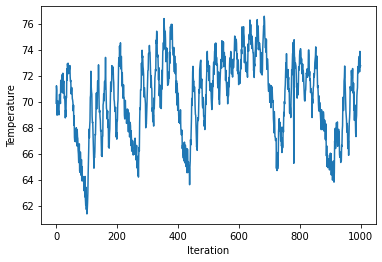

In [ ]:
plt.plot(training_set, label = 'ambient_temperature_system_failure')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.show()

##Dataloading

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler() #scaling so that value variation doesnt affect much
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x))) #Variable function is of pytorch
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
print(dataX)

tensor([[[0.5601],
         [0.6482],
         [0.6257],
         [0.4995]],

        [[0.6482],
         [0.6257],
         [0.4995],
         [0.5208]],

        [[0.6257],
         [0.4995],
         [0.5208],
         [0.5719]],

        ...,

        [[0.7141],
         [0.7793],
         [0.7756],
         [0.7977]],

        [[0.7793],
         [0.7756],
         [0.7977],
         [0.7192]],

        [[0.7756],
         [0.7977],
         [0.7192],
         [0.8222]]])


In [ ]:
print(dataY)

tensor([[0.5208],
        [0.5719],
        [0.5206],
        [0.5265],
        [0.5131],
        [0.5013],
        [0.5656],
        [0.6045],
        [0.5882],
        [0.5841],
        [0.5584],
        [0.6760],
        [0.6499],
        [0.6169],
        [0.6583],
        [0.6860],
        [0.7055],
        [0.6701],
        [0.7118],
        [0.6107],
        [0.6562],
        [0.6723],
        [0.6322],
        [0.5840],
        [0.5964],
        [0.5514],
        [0.4857],
        [0.5253],
        [0.4925],
        [0.5888],
        [0.5877],
        [0.7344],
        [0.6760],
        [0.7601],
        [0.7414],
        [0.7625],
        [0.7095],
        [0.7104],
        [0.7196],
        [0.7246],
        [0.7397],
        [0.7505],
        [0.6940],
        [0.6701],
        [0.6752],
        [0.6072],
        [0.6240],
        [0.6393],
        [0.6237],
        [0.5832],
        [0.5764],
        [0.5633],
        [0.5210],
        [0.5499],
        [0.4489],
        [0

##Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes #output shape for fully connected block
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size #input shape for fully connected block
        self.seq_length = seq_length
        
        #1. lstm block
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #2. fully connected block
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        return out

      

In [ ]:
#LSTM
#1,2,1

#FC
#accuracy = yactual - ypredict


##Training

In [ ]:
num_epochs = 200 #500 #3000 #1500 #200 #2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# losses = []
# # Train the model
# for epoch in range(num_epochs):
#     outputs = lstm(trainX)
#     optimizer.zero_grad()
    
#     # obtain the loss function
#     loss = criterion(outputs, trainY)
    
#     loss.backward()
    
#     optimizer.step()
#     losses.append(loss.item())
#     if epoch % 100 == 0:
#       print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
training_losses, validation_losses , accuracy=[],[],[]
# losses = []

# Train the model (training loop)
for epoch in range(num_epochs):
  
  #training
    lstm.train()
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    #validation
    lstm.eval()
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    validation_losses.append(loss.item())

    # #accuracy
    # outputs = lstm(trainX)
    # train_accuracy = torchmetrics.Accuracy()
    # accuracy=train_accuracy(outputs,trainY)

    if epoch % 5 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04210
Epoch: 5, loss: 0.04049
Epoch: 10, loss: 0.03914
Epoch: 15, loss: 0.03702
Epoch: 20, loss: 0.03355
Epoch: 25, loss: 0.02847
Epoch: 30, loss: 0.02170
Epoch: 35, loss: 0.01400
Epoch: 40, loss: 0.00822
Epoch: 45, loss: 0.00746
Epoch: 50, loss: 0.00778
Epoch: 55, loss: 0.00677
Epoch: 60, loss: 0.00687
Epoch: 65, loss: 0.00657
Epoch: 70, loss: 0.00619
Epoch: 75, loss: 0.00609
Epoch: 80, loss: 0.00590
Epoch: 85, loss: 0.00578
Epoch: 90, loss: 0.00567
Epoch: 95, loss: 0.00553
Epoch: 100, loss: 0.00540
Epoch: 105, loss: 0.00527
Epoch: 110, loss: 0.00515
Epoch: 115, loss: 0.00502
Epoch: 120, loss: 0.00489
Epoch: 125, loss: 0.00476
Epoch: 130, loss: 0.00463
Epoch: 135, loss: 0.00449
Epoch: 140, loss: 0.00436
Epoch: 145, loss: 0.00422
Epoch: 150, loss: 0.00409
Epoch: 155, loss: 0.00397
Epoch: 160, loss: 0.00385
Epoch: 165, loss: 0.00375
Epoch: 170, loss: 0.00366
Epoch: 175, loss: 0.00362
Epoch: 180, loss: 0.00355
Epoch: 185, loss: 0.00350
Epoch: 190, loss: 0.00347
Epoch: 1

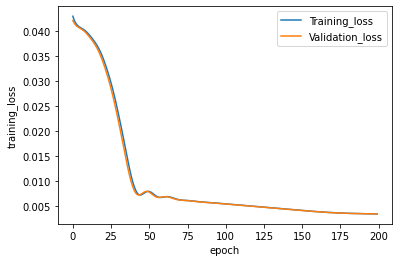

In [ ]:
# #loss vs epoch graph
# plt.plot(losses, label = 'Loss vs Epoch during training')
# plt.xlabel('epoch')
# plt.ylabel('training_loss')
# plt.show()

#loss vs epoch graph
plt.plot(training_losses, label = 'Loss vs Epoch during training')
plt.plot(validation_losses)
plt.xlabel('epoch')
plt.ylabel('training_loss')
plt.legend(['Training_loss', 'Validation_loss'])
plt.show()

##Testing for Ambient Temperature System Failure



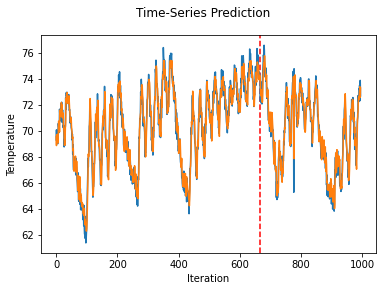

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.show()

##Graph


In [ ]:
!pip install torchviz 

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=741df37db9f585da2aac4ab08f1536ad60fbd144f33e64657ca300c3712d2dd1
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
from torchviz import make_dot

In [ ]:
dummy_batch = lstm(dataX)
with torch.no_grad():
  image = make_dot(dummy_batch, params=dict(list(lstm.named_parameters()))).render("rnn_torchviz", format="png")

In [ ]:
image

'rnn_torchviz.png'

In [ ]:
!pip install hiddenlayer

In [ ]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(lstm, dataX, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2123: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


In [ ]:
!pip install netron

     |████████████████████████████████| 1.4 MB 7.9 MB/s 


In [ ]:
#input_names = ['Sentence']
#output_names = ['yhat']
torch.onnx.export(lstm, dataX, 'rnn.onnx')

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2123: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


In [ ]:
#Dont need to run again
#Save Model
#!cd ServerTemperaturePrediction
torch.save(lstm.state_dict(), '/content/drive/MyDrive/ServerTemperaturePrediction/model.pt')

#Dont need to run again
#Load Model
model2 = LSTM(num_classes, input_size, hidden_size, num_layers)
model2.load_state_dict(torch.load('/content/drive/MyDrive/ServerTemperaturePrediction/model.pt'))
model2.eval() #here input would be given

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

### Reference: https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch


1. Generate accuracy for test dataset
2. Generate loss graph for dataset
3. Generate layer graph